Imports and Config

In [1]:
# Cell 1: imports and config
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import time
import math

# ---------- Config ----------
NUM_RX = 1         # number of receive antennas (for simplicity)
NUM_TX = 1
N_SUBC = 30        # number of OFDM subcarriers (small example)
FS = 100           # samples per second (time steps)
DURATION = 5.0     # seconds to simulate
WINDOW = 0.5       # seconds for feature window
# ----------------------------
T = int(FS * DURATION)
window_len = int(FS * WINDOW)

print("T:", T, "window_len:", window_len)


T: 500 window_len: 50


Synthetic CSI generator function

In [3]:
# Cell 2: CSI generation helper
def generate_csi_sample(t_index, n_subc=N_SUBC, moving_speed=0.5):
    """
    Simple synthetic CSI model:
    - Several multipath components with random delays and amplitudes.
    - Time-varying Doppler shift on each path to simulate motion
    Returns complex vector shape (n_subc,)
    """
    n_paths = 3
    freqs = np.linspace(-0.5, 0.5, n_subc)  # relative subcarrier freq bins
    csi = np.zeros(n_subc, dtype=np.complex128)

    for p in range(n_paths):
        amp = 0.5 + 0.5 * np.random.rand()
        delay = np.random.uniform(0.0, 1.0)
        doppler = moving_speed * (0.2 + 0.8 * np.random.rand())
        phase = 2*np.pi*(doppler * (t_index/FS)) + 2*np.pi*np.random.rand()
        freq_phase = np.exp(-2j*np.pi*delay*freqs)
        csi += amp * freq_phase * np.exp(1j*phase)
    # add noise
    csi += (np.random.randn(n_subc) + 1j*np.random.randn(n_subc)) * 0.05
    return csi


Circular buffer and feature extractor

In [4]:
# Cell 3: buffer and feature extraction
class CircularCSI:
    def __init__(self, maxlen):
        self.q = deque(maxlen=maxlen)

    def push(self, sample):
        self.q.append(sample)

    def get_matrix(self):
        if not self.q:
            return np.zeros((0, N_SUBC), dtype=np.complex128)
        return np.vstack(self.q)

def extract_features(csi_matrix):
    if csi_matrix.shape[0] == 0:
        return None
    amps = np.abs(csi_matrix)
    phases = np.angle(csi_matrix)
    phases_unwrapped = np.unwrap(phases, axis=0)
    amp_mean = np.mean(amps)
    amp_std = np.std(amps)
    ph_mean = np.mean(phases_unwrapped)
    ph_std = np.std(phases_unwrapped)
    feat = np.array([amp_mean, amp_std, ph_mean, ph_std])
    return feat


Run simulation & collect features

In [5]:
# Cell 4: run simulation (short demo)
cb = CircularCSI(window_len)
feats = []
for t in range(T):
    sample = generate_csi_sample(t)
    cb.push(sample)
    if t >= window_len - 1:
        mat = cb.get_matrix()
        feat = extract_features(mat)
        feats.append(feat)
    # remove / reduce sleep in notebooks so cells run faster
    # time.sleep(1.0 / FS * 0.2)

feats = np.array(feats)
print("Features shape:", feats.shape)


Features shape: (451, 4)


Plot results inline

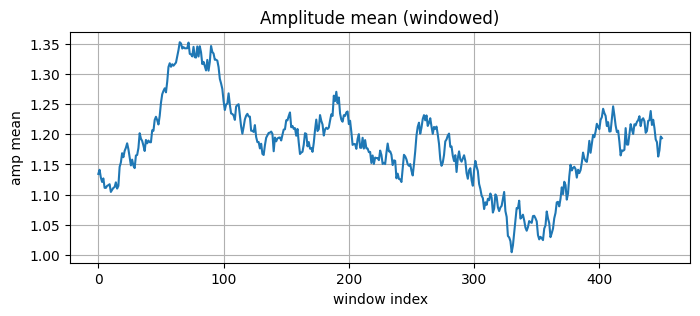

In [6]:
# Cell 5: plot amplitude mean over time inline
plt.figure(figsize=(8,3))
plt.plot(feats[:,0])
plt.title("Amplitude mean (windowed)")
plt.xlabel("window index")
plt.ylabel("amp mean")
plt.grid(True)
plt.show()
